Examples of hypothesis testing, feature engineering, feature selection, model tuning, data visualisation and interpretation

In [41]:
import sys
sys.path += ['C:\\Program Files\\Python37\\lib\\site-packages']
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost
import tensorflow as tf
from tensorflow.keras import layers
import shap
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_auc_score
import hyperopt.exceptions
from hyperopt import hp, tpe, fmin

In [2]:
data = pd.read_csv("radon.csv")
data.columns = [col.replace(' ', '') for col in data.columns]
with pd.option_context('display.max_columns', None):
    display(data)
data.info()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,windoor,rep,stratum,wave,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
0,1,AZ,AZ,4,85920,1,1,1,2,N,,2,1,30,1100,1100,112987,120287,0.3,0.0,136.060971,0,0,1,APACHE
1,2,AZ,AZ,4,85920,1,0,9,0,,,1,1,117,600,700,70788,71188,0.6,33.3,128.784975,0,0,1,APACHE
2,3,AZ,AZ,4,85924,1,1,1,3,N,,4,1,122,1145,1145,70788,70788,0.5,0.0,150.245112,0,0,1,APACHE
3,4,AZ,AZ,4,85925,1,1,1,3,N,,2,1,3,1900,1900,52088,52288,0.6,97.2,136.060971,0,0,1,APACHE
4,5,AZ,AZ,4,85932,1,1,1,1,N,,2,1,118,800,900,70788,70788,0.3,0.0,136.060971,0,0,1,APACHE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12772,12773,R5,WI,55,54660,4,1,0,4,Y,,.,27,.,900,900,30388,30388,0.6,28.0,4.761628,0,0,81,WISCONSIN WINNEBAGO
12773,12774,R5,WI,55,54660,4,1,1,3,N,,.,27,.,1530,1615,30388,30388,2.2,14.5,4.761628,0,0,81,WISCONSIN WINNEBAGO
12774,12775,R5,WI,55,54660,4,1,1,3,Y,,.,27,.,845,830,31588,31788,0.4,0.0,4.761628,0,0,81,WISCONSIN WINNEBAGO
12775,12776,R5,WI,55,54660,4,1,1,3,N,,.,27,.,815,730,31588,31788,0.3,0.0,4.761628,0,0,81,WISCONSIN WINNEBAGO


Data cleaning

In [3]:
# remove meaningless columns
data.drop(axis=1, labels=['idnum', 'dupflag', 'pcterr'], inplace=True)

# data cleaning: remove duplicates and NaN rows
data.drop_duplicates(inplace=True)
data.dropna(axis=1, inplace=True, how='all')

In [4]:
for col in data.columns:
    print(data[col].value_counts())

PA    2389
IN    1914
MO    1859
MA    1659
ND    1596
AZ    1507
R5     934
MN     919
Name: state, dtype: int64
PA    2389
IN    1914
MO    1859
MA    1659
ND    1596
AZ    1507
MN    1188
WI     461
MI     204
Name: state2, dtype: int64
42    2389
18    1914
29    1859
25    1659
38    1596
4     1507
27    1188
55     461
26     204
Name: stfips, dtype: int64
58201    139
54135    129
58601    101
58554     71
58103     68
        ... 
17103      1
01074      1
85618      1
02537      1
46705      1
Name: zip, Length: 3195, dtype: int64
3     2741
1     2399
4     2040
2     1635
5     1369
6     1108
7      408
9      375
8      361
10     266
11      75
Name: region, dtype: int64
1    11510
0      624
2      483
5      151
3        9
Name: typebldg, dtype: int64
0    8465
1    3983
9     287
2      23
3      19
Name: floor, dtype: int64
4    5068
2    2095
3    1717
1    1578
0    1219
7     982
5     115
6       3
Name: room, dtype: int64
Y    8640
N    3384
      679
0      74


In [5]:
data[data['state'] != data['state2']].shape

(934, 22)

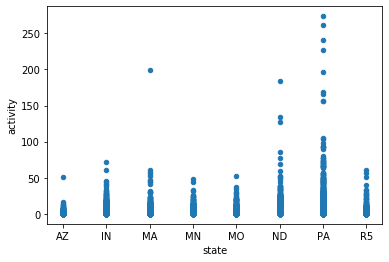

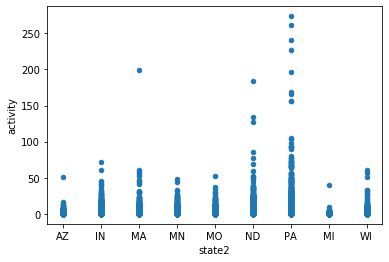

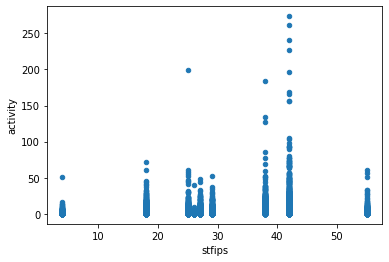

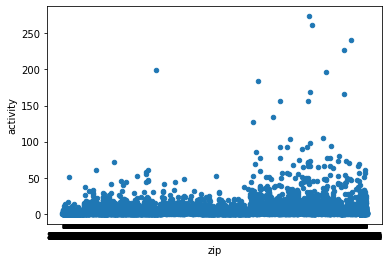

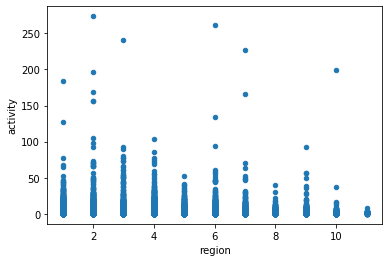

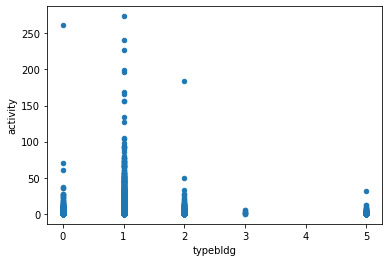

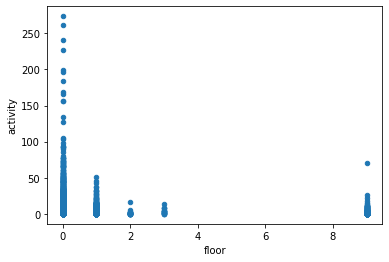

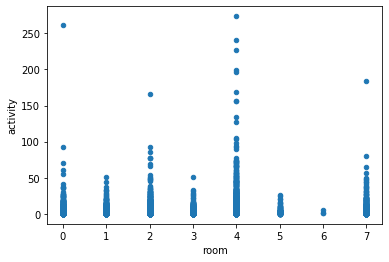

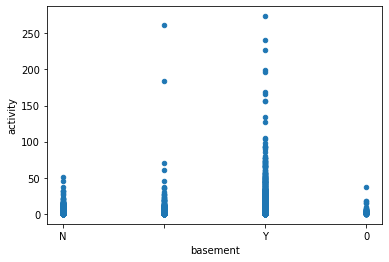

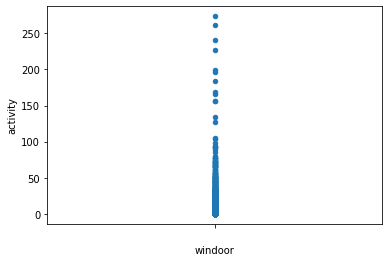

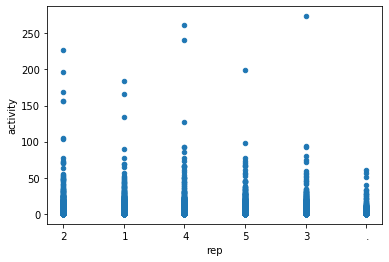

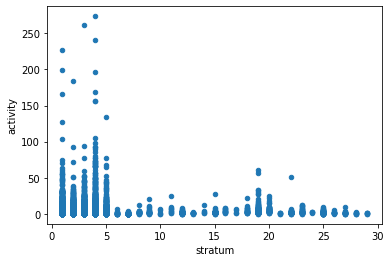

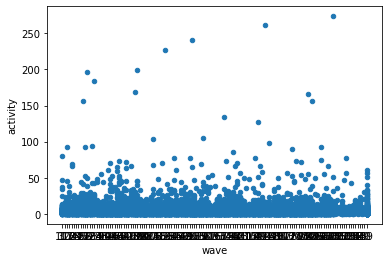

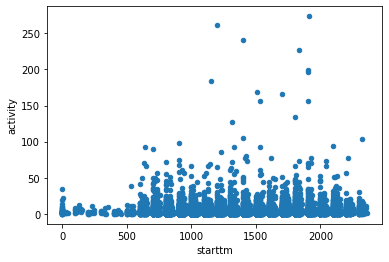

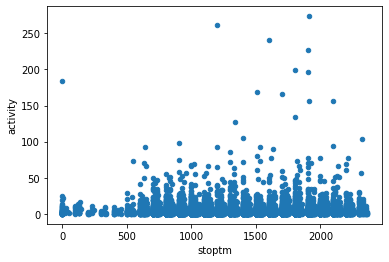

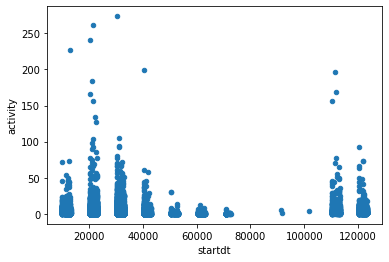

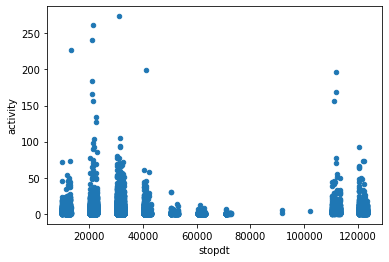

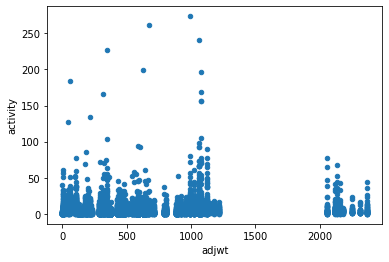

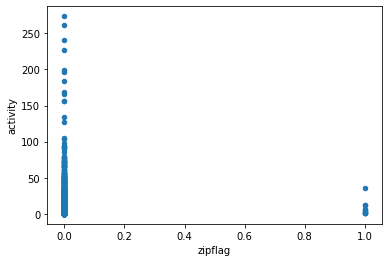

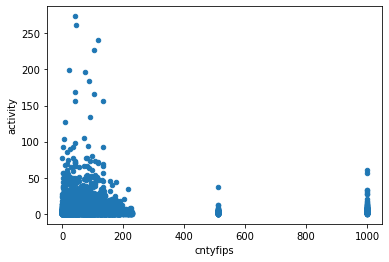

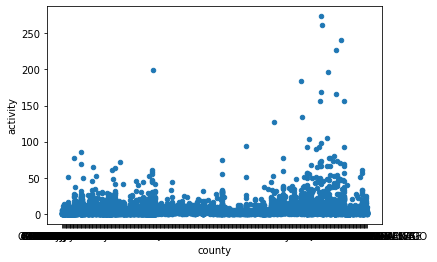

In [6]:
# scatter plot all features & calculate correlation with label
labelcol = 'activity'
labels = data[labelcol].values

for col in data.columns:
    if col != labelcol: 
        data[[col, labelcol]].plot.scatter(x=col, y=labelcol)
        plt.show()

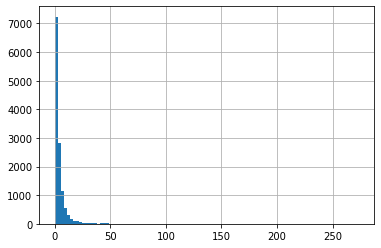

In [7]:
data[labelcol].hist(bins=100)

Feature encoding

In [8]:
# choose these features to encode
features_onehot = ['state', 'region', 'typebldg', 'basement']
features_numerical = ['floor', 'stoptm', 'stfips', 'stratum', 'room']
features_ordinal = ['county']

# feature encoding
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

numerical_encoder = StandardScaler() # scale numerical columns
# normalise, standardise, log scale?
data_enc = pd.DataFrame(numerical_encoder.fit_transform(data[features_numerical]), columns=features_numerical)

onehot_encoded = pd.get_dummies(data[features_onehot])
data_enc = pd.concat((data_enc, onehot_encoded), axis=1) # one-hot encoding

ordinal_encoder = OrdinalEncoder()
ordinal_encoded = ordinal_encoder.fit_transform(data[features_ordinal])
data_enc = pd.concat((data_enc, pd.DataFrame(ordinal_encoded, columns=features_ordinal)), axis=1) # one-hot encoding

data_enc

,floor,stoptm,stfips,stratum,room,region,typebldg,state_AZ,state_IN,state_MA,state_MN,state_MO,state_ND,state_PA,state_R5,basement_,basement_0,basement_N,basement_Y,county
0,0.348714,-0.620104,-1.909837,-0.589181,-0.575083,1,1,1,0,0,0,0,0,0,0,0,0,1,0,8.0
1,6.184367,-1.433604,-1.909837,-0.589181,-1.696548,1,0,1,0,0,0,0,0,0,0,1,0,0,0,8.0
2,0.348714,-0.528586,-1.909837,-0.589181,-0.014351,1,1,1,0,0,0,0,0,0,0,0,0,1,0,8.0
3,0.348714,1.006895,-1.909837,-0.589181,-0.014351,1,1,1,0,0,0,0,0,0,0,0,0,1,0,8.0
4,0.348714,-1.026854,-1.909837,-0.589181,-1.135815,1,1,1,0,0,0,0,0,0,0,0,0,1,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12772,-0.380742,-1.026854,2.124478,5.753240,0.546382,4,1,0,0,0,0,0,0,0,1,0,0,0,1,377.0
12773,0.348714,0.427277,2.124478,5.753240,-0.014351,4,1,0,0,0,0,0,0,0,1,0,0,1,0,377.0
12774,0.348714,-1.169217,2.124478,5.753240,-0.014351,4,1,0,0,0,0,0,0,0,1,0,0,0,1,377.0
12775,0.348714,-1.372591,2.124478,5.753240,-0.014351,4,1,0,0,0,0,0,0,0,1,0,0,1,0,377.0


Model training: classifier with equal balance of classes

In [9]:
labels_binary = [1 if l>10 else 0 for l in labels] # make binary class labels

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:50<00:00,  1.35trial/s, best loss: -0.7791350054736301]
[00:27:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { lr } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse-mean-rmse:0.40102	eval-rmse-mean-rmse:0.39924
[10]	train-rmse-mean-rmse:0.26486	eval-rmse-mean-rmse:0.26092
[20]	train-rmse-mean-rmse:0.25956	eval-rmse-mean-rmse:0.26101
[30]	train-rmse-mean-rmse:0.25474	eval-rmse-mean-rmse:0.26112
[40]	train-rmse-mean-rmse:0.25119	eval-rmse-mean-rmse:0.26214
[50]	train-rmse-mean-rmse:0.24829	eval-rmse-mean-rmse:0.26244
[60]	train-r

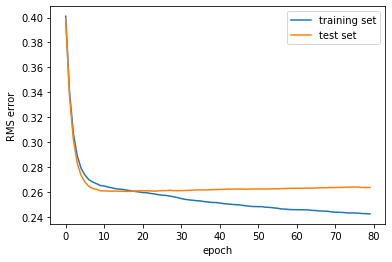

0.7561930500998132


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


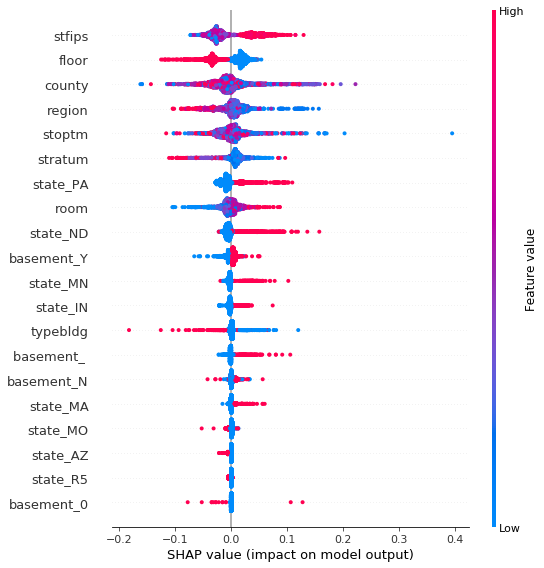

In [47]:
# XGBoost
X_train, X_test, y_train, y_test = train_test_split(data_enc.to_numpy(), np.array(labels_binary), test_size=0.2)

trainmatrix, testmatrix = xgboost.DMatrix(X_train, label=y_train), xgboost.DMatrix(X_test, label=y_test)

# optimse hyperparameters
def optimise(*args):
    colsample, lr, max_depth = args[0]
    params = {'colsample_bytree': colsample, 'learning_rate': lr, 'max_depth': max_depth}
    return -optimfct(params)
            
def optimfct(params, plot_loss=False):
    epochs = 80
    progress = {}
    if plot_loss: watchlist  = [(trainmatrix,'train-rmse-mean'), (testmatrix, 'eval-rmse-mean')]
    model = xgboost.train(params, trainmatrix, epochs, evals=watchlist if plot_loss else (), evals_result=progress, verbose_eval=10 if plot_loss else False)
    
    if plot_loss:
        # plot training performance
        plt.plot(range(len(progress['train']['rmse-mean-rmse'])), progress['train']['rmse-mean-rmse'], label='training set')
        plt.plot(range(len(progress['eval']['rmse-mean-rmse'])),  progress['eval']['rmse-mean-rmse'],  label='test set')
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMS error")
        plt.show()
        
        roc_score = roc_auc_score(y_test, model.predict(xgboost.DMatrix(X_test)))
        print(roc_score, params)
        
        return roc_score, model
    
    return roc_auc_score(y_test, model.predict(xgboost.DMatrix(X_test)))

# define hyperparameter search space
space = [hp.uniform('colsample_bytree', 0.5, 1.0), 
         hp.loguniform('lr', -3.5*np.log(10), 0*np.log(10)), 
         hp.choice('max_depth', range(3, 9))]

best_params = fmin(fn=optimise, space=space, algo=tpe.suggest, max_evals=150)
_, model = optimfct(best_params, plot_loss=True)

# explain using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_values_train = explainer.shap_values(X_train)

# summarize the effects of all the features
shap.summary_plot(shap_values, X_test, feature_names=data_enc.columns, max_display=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 10221 samples, validate on 2556 samples
Epoch 1/40
10221/10221 [==============================] - 1s 97us/sample - loss: 7.9110 - val_loss: 0.1486
Epoch 2/40
10221/10221 [==============================] - 0s 23us/sample - loss: 1.9673 - val_loss: 0.0932
Epoch 3/40
10221/10221 [==============================] - 0s 24us/sample - loss: 0.8626 - val_loss: 0.2624
Epoch 4/40
10221/10221 [==============================] - 0s 23us/sample - loss: 0.5667 - val_loss: 0.0420
Epoch 5/40
10221/10221 [==============================] - 0s 23us/sample - loss: 0.3824 - val_loss: 0.3328
Epoch 6/40
10221/10221 [==============================] - 0s 23us/sample - loss: 0.2797 - val_loss: 0.1251
Epoch 7/40
10221/10221 [==============================] - 0s 22us/sample - loss: 0.2167 - val_loss: 0.0503
Epoch 8/40
10221/10221 [==============================] - 0s 23us/sample - loss: 0.1794 - val_loss: 0.0515
Epoch 9/40
10221/10221 [=====================

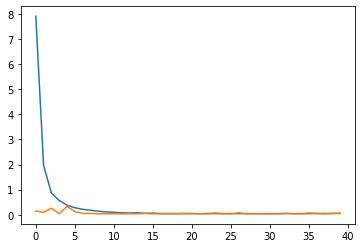

0.6919984982000487


In [10]:
# FC NN
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              #loss=tf.keras.losses.BinaryCrossentropy(),
              loss=tf.keras.losses.MeanSquaredError(),
              )

weights = {1:1-sum(labels_binary)/len(labels_binary), 0: sum(labels_binary)/len(labels_binary)}

X_train, X_test, y_train, y_test = train_test_split(data_enc.to_numpy(), np.array(labels_binary), test_size=0.2)

history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
                    epochs=40, class_weight=weights, batch_size=100)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

print(roc_auc_score(y_test, model.predict(X_test)))

(10221, 20) (2556, 20)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 10221 samples, validate on 2556 samples
Epoch 1/40
10221/10221 [==============================] - 1s 120us/sample - loss: 0.0476 - val_loss: 0.0407
Epoch 2/40
10221/10221 [==============================] - 1s 55us/sample - loss: 0.0363 - val_loss: 0.0367
Epoch 3/40
10221/10221 [==============================] - 1s 55us/sample - loss: 0.0342 - val_loss: 0.0359
Epoch 4/40
10221/10221 [==============================] - 1s 54us/sample - loss: 0.0353 - val_loss: 0.0347
Epoch 5/40
10221/10221 [==============================] - 1s 56us/sample - loss: 0.0327 - val_loss: 0.0344
Epoch 6/40
10221/10221 [==============================] - 1s 54us/sample - loss: 0.0329 - val_loss: 0.0338
Epoch 7/40
10221/10221 [==============================] - 1s 55us/sample - loss: 0.0326 - val_loss: 0.0363
Epoch 8/40
10221/10221 [==============================] - 1s 54us/sample - loss: 0.0328 - val_loss: 0.0341
Epoch 9/40
10221/1022

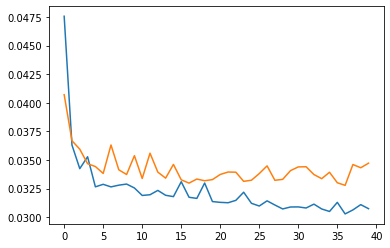

0.7605266151765285


In [11]:
# CNN
model = tf.keras.Sequential([
    layers.Reshape((20,1), input_shape=(20,)),
    layers.Conv1D(64, 5, activation='relu'),
    layers.Dropout(0.1),
    layers.Conv1D(32, 5, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              #loss=tf.keras.losses.BinaryCrossentropy(),
              loss=tf.keras.losses.MeanSquaredError(),
              )

weights = {1:1-sum(labels_binary)/len(labels_binary), 0: sum(labels_binary)/len(labels_binary)}

X = data_enc.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels_binary), test_size=0.2)
print(X_train.shape, X_test.shape)

#earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True, verbose=1)
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
                    epochs=40, class_weight=weights, batch_size=300, callbacks=[])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

print(roc_auc_score(y_test, model.predict(X_test)))

In [12]:
# explain using SHAP
inds = np.random.choice(X_train.shape[0], 10, replace=False)
explainer = shap.DeepExplainer(model, X_train[inds, :])
shap_values = explainer.shap_values(X_test)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


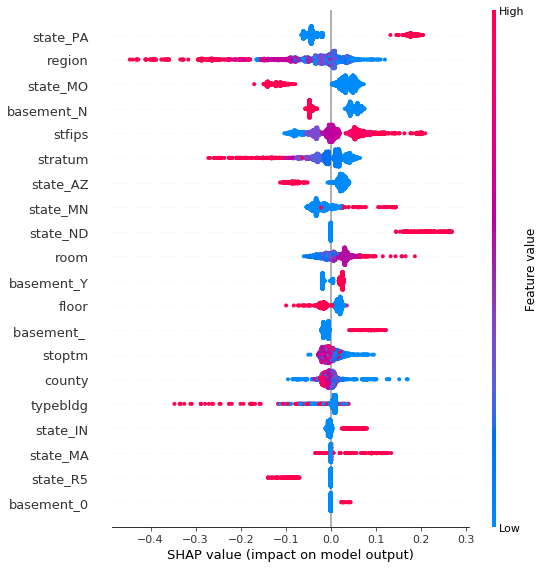

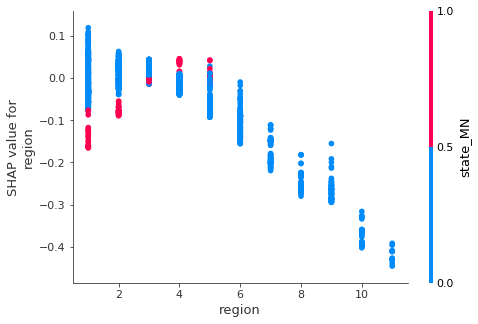

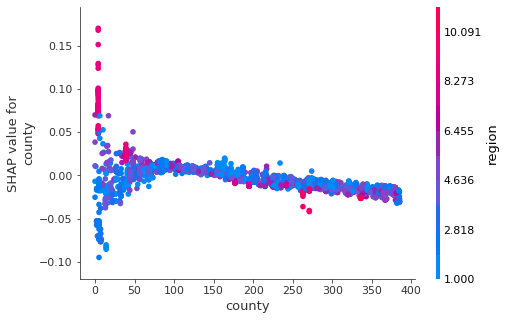

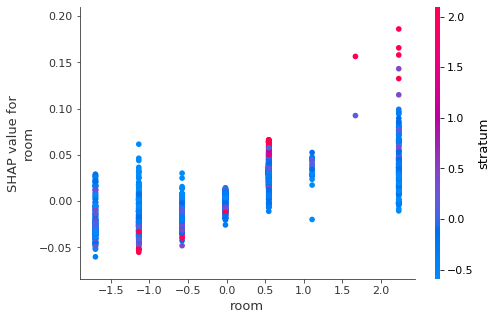

In [13]:
shap.summary_plot(shap_values[0], X_test, feature_names=data_enc.columns, plot_type="dot", max_display=50)
shap.dependence_plot('region', shap_values[0], X_test, dot_size=32, feature_names=data_enc.columns)
shap.dependence_plot('county', shap_values[0], X_test, dot_size=32, feature_names=data_enc.columns)
shap.dependence_plot('room', shap_values[0], X_test, dot_size=32, feature_names=data_enc.columns)
shap.force_plot(explainer.expected_value.numpy(), shap_values[0][0], X_test[0], feature_names=data_enc.columns)

In [14]:
# for ordinal features, invert transformation and plot (global) SHAP values

# for one-hot encoded features, collect all matching columns and plot (global) SHAP values

Train regressor (transform label using nonlinear transformation, e.g. log)

(array([  90.,    0.,  304.,  884., 3657., 4448., 2617.,  649.,  113.,
          15.]),
 array([-4.60517019, -3.58351935, -2.56186851, -1.54021767, -0.51856684,
         0.503084  ,  1.52473484,  2.54638567,  3.56803651,  4.58968735,
         5.61133818]),
 <a list of 10 Patch objects>)

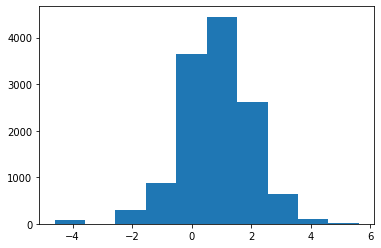

In [48]:
plt.hist(np.log(np.array(labels)+0.01))

(10221, 20) (2556, 20)
Train on 10221 samples, validate on 2556 samples
Epoch 1/40
10221/10221 [==============================] - 1s 112us/sample - loss: 1.7669 - val_loss: 1.2550
Epoch 2/40
10221/10221 [==============================] - ETA: 0s - loss: 1.313 - 0s 47us/sample - loss: 1.3049 - val_loss: 1.1296
Epoch 3/40
10221/10221 [==============================] - 0s 46us/sample - loss: 1.1890 - val_loss: 1.0789
Epoch 4/40
10221/10221 [==============================] - 0s 46us/sample - loss: 1.1663 - val_loss: 1.0724
Epoch 5/40
10221/10221 [==============================] - 0s 48us/sample - loss: 1.1538 - val_loss: 1.0638
Epoch 6/40
10221/10221 [==============================] - 1s 54us/sample - loss: 1.1396 - val_loss: 1.0661
Epoch 7/40
10221/10221 [==============================] - 1s 60us/sample - loss: 1.1327 - val_loss: 1.0647
Epoch 8/40
10221/10221 [==============================] - 1s 69us/sample - loss: 1.1362 - val_loss: 1.0554
Epoch 9/40
10221/10221 [=======================

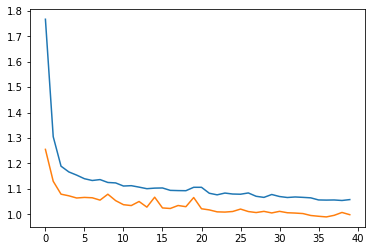

0.528178787193849


In [23]:
model = tf.keras.Sequential([
    layers.Reshape((20,1), input_shape=(20,)),
    layers.Conv1D(64, 5, activation='relu'),
    layers.Dropout(0.1),
    layers.Conv1D(32, 5, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              #loss=tf.keras.losses.BinaryCrossentropy(),
              loss=tf.keras.losses.MeanSquaredError(),
              )

# logarithmic labels
X_train, X_test, y_train, y_test = train_test_split(X, np.log(np.array(labels)+0.01), test_size=0.2)
print(X_train.shape, X_test.shape)

history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
                    epochs=40, batch_size=300, callbacks=[])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

from scipy.stats import pearsonr
ypred = model.predict(X_test)
ypred = np.array([y[0] for y in ypred]) # flatten last dimension
print(pearsonr(y_test, ypred)[0])